# Astronomical Data Processing

### Léo BECHET - M2 CompuPhys - 2024-2025

In [1]:
import numpy as np
from astropy.io import fits
from scipy.signal import correlate2d
import matplotlib.pyplot as plt


In [2]:
def instrumental_mag(F_obj: float , t_exp: float):
    return -2.5 * np.log(F_obj/t_exp)

2508559.9324582308


/home/leo/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_513377/2437244814.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Magnitude=-2.5*log10(Sum_target)
/tmp/ipykernel_513377/2437244814.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sky_magnitude = -2.5 * log10(Sky_flux)


{'mjd': 52190.2302431,
 'exptime': 180.0,
 'magnitude': -13.792333471140468,
 'sky': -9.49341122491907}

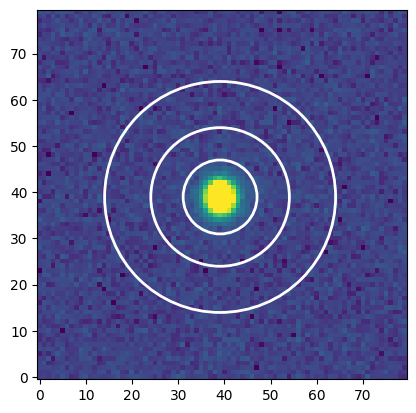

In [3]:


# Adaptation of what's going in in the given file idk....

#  File M2_CompuPhys_Data_Processing.py for Astronomical data processing course
#
#  Example of Python code for measuring magnitudes in a fits image... Needs to be adapted !

filename = "data/8_Oct/td10r_n2_0133.fits"


r=8         # radius for measuring target flux
r_in=15     # inner radius for the annulus used for measuring sky background
r_out=25    # outer radius for the annulus used for measuring sky background 


Xcent=1085     # approximate target coordinates (x)
Ycent=660      # approximate target coordinates (y)


def GivenFileThingy(filename, r, r_in, r_out, Xcent, Ycent, side,debug=False):

    hdulist = fits.open(filename)       # Define the image name to open
    if debug: hdulist.info()                                  # To get information on the image

    header = hdulist[0].header

    scidata = hdulist[0].data                 # transfer the image (pixels values) in scidata
    if debug: print("data shape : ", scidata.shape)
    mjd = header['MJD-OBS']
    if debug: print("mjd : ", mjd)
    exptime = header['EXPTIME']
    if debug: print("exposition : ", exptime," secs")

    #print(repr(header))                # to print all the descriptors in the header, if necessary
    #print(repr(header['MJD-OBS']))     # to print a given descriptor, if necessary
    #scidata /= exptime                # divide the image by its exposure time, if necessary


    from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
    from astropy.visualization import simple_norm



    from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg, centroid_quadratic
    data = scidata[Ycent-side:Ycent+side,Xcent-side:Xcent+side]  # subimage centered on the target

    x1, y1 = centroid_quadratic(data)     # for computing accurately the position of maximum of brightness
    if debug: print('resultats centroid =%.3f'%(x1),',%.3f'%(y1))


    norm = simple_norm(data, 'sqrt', percent=99)
    plt.imshow(data, norm=norm, origin='lower')
    positions = [(x1, y1)]
    aperture = CircularAperture(positions, r)
    annulus_aperture = CircularAnnulus(positions, r_in, r_out)

    aperture.plot(color='white', lw=2)
    annulus_aperture.plot(color='white', lw=2)


    phot_table = aperture_photometry(data, aperture)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    if debug: print(phot_table)
    Sum_target_raw=(phot_table['aperture_sum'])

    if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))

    phot_table = aperture_photometry(data, annulus_aperture)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    if debug: print(phot_table)
    Sky_background=(phot_table['aperture_sum'])

    if debug: print('\nSky_background=%.3f\n'%(Sky_background))





    from math import log10
    Sum_target=Sum_target_raw-Sky_background/(r_out*r_out-r_in*r_in)*(r*r)
    if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
    Magnitude=-2.5*log10(Sum_target)
    if debug: print('instrumental magnitude=%.3f\n'%(Magnitude))

    Sky_flux = Sky_background / (r_out * r_out - r_in * r_in)  # Sky flux density per pixel
    Sky_magnitude = -2.5 * log10(Sky_flux)

    print(Sky_background[0])

    hdulist.close()

    if debug: plt.show()

    return {
        "mjd": mjd,
        "exptime": exptime,
        "magnitude": Magnitude,
        "sky": Sky_magnitude
    }



GivenFileThingy(filename, r, r_in, r_out, Xcent, Ycent, 40)


# Frame Alignment

 

In [4]:
import numpy as np
from astropy.io import fits
from scipy.signal import correlate2d
import matplotlib.pyplot as plt

def CreateOffsetArray(files, ref_star, bounding_size, Debug=False, Verbose=False):
    """
    Compute the pixel offsets between images based on the reference star's position, with optional debugging plots.
    
    Parameters:
    - files: list of strings, paths to FITS files.
    - ref_star: tuple (Xcent, Ycent), initial coordinates of the reference star in the first image.
    - bounding_size: integer, size of the bounding box (half-width) around the reference star.
    - Debug: boolean, if True, plots the bounding box and star position for each image.
    
    Returns:
    - offsets: list of tuples, containing pixel offsets (dx, dy) for each image relative to the first.
    """
    
    # Initialize an empty list to store offsets
    offsets = []
    
    # Open the first image and extract the reference subimage
    hdulist = fits.open(files[0])
    scidata = hdulist[0].data
    Xcent, Ycent = ref_star
    ref_subimage = scidata[Ycent-bounding_size:Ycent+bounding_size, Xcent-bounding_size:Xcent+bounding_size]
    
    # Initialize the first image's offset as (0, 0)
    offsets.append((0, 0))
    
    if Debug:
        plt.figure(figsize=(10, 5))
    
    # Iterate over the rest of the images
    for i in range(1, len(files)):
        if Verbose: print(f' Aligning image {i}/{len(files)}')
        # Open the current image
        hdulist = fits.open(files[i])
        scidata = hdulist[0].data
        
        # Extract the subimage around the current reference star position
        curr_subimage = scidata[Ycent-bounding_size:Ycent+bounding_size, Xcent-bounding_size:Xcent+bounding_size]
        
        # Perform cross-correlation to find the shift
        correlation = correlate2d(curr_subimage, ref_subimage, mode='same')
        max_loc = np.unravel_index(np.argmax(correlation), correlation.shape)
        offset_y = max_loc[0] - correlation.shape[0] // 2
        offset_x = max_loc[1] - correlation.shape[1] // 2
        
        # Update the reference star's position for the next image
        Xcent += offset_x
        Ycent += offset_y
        
        # Add the computed offset to the list
        offsets.append((offset_x, offset_y))
        if Verbose: print(f'    Offset : {(offset_x, offset_y)}')
        
        # Debug plotting
        if Debug:
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            
            # Show the full image with bounding box
            ax[0].imshow(scidata, cmap='gray', origin='lower')
            rect = plt.Rectangle((Xcent-bounding_size, Ycent-bounding_size), 2*bounding_size, 2*bounding_size,
                                 linewidth=1, edgecolor='r', facecolor='none')
            ax[0].add_patch(rect)
            ax[0].scatter(Xcent, Ycent, color='blue', label='New Star Position')
            ax[0].set_title(f"Image {i + 1}: Full Image with Bounding Box")
            ax[0].legend()
            
            # Show the subimage for clarity
            ax[1].imshow(curr_subimage, cmap='gray', origin='lower')
            ax[1].set_title(f"Image {i + 1}: Subimage Around Star")
            
            plt.show()
    
    return offsets


In [5]:
def compute_absolute_offsets(relative_offsets):
    """
    Compute the absolute offsets from a list of relative offsets.
    
    Parameters:
    - relative_offsets: list of tuples, each containing the relative offset (dx, dy) from the previous frame.
    
    Returns:
    - absolute_offsets: list of tuples, each containing the absolute offset (dx, dy) from the first frame.
    """
    
    # Initialize the absolute offsets list
    absolute_offsets = []
    
    # Initialize the cumulative offset (start with 0, 0 for the first frame)
    cumulative_offset_x = 0
    cumulative_offset_y = 0
    
    # Loop through each relative offset and accumulate to get the absolute offset
    for dx, dy in relative_offsets:
        # Update the cumulative offset
        cumulative_offset_x += dx
        cumulative_offset_y += dy
        
        # Append the new absolute offset to the list
        absolute_offsets.append((cumulative_offset_x, cumulative_offset_y))
    
    return absolute_offsets

['data/8_Oct/td10r_n2_0096.fits', 'data/8_Oct/td10r_n2_0098.fits', 'data/8_Oct/td10r_n2_0100.fits', 'data/8_Oct/td10r_n2_0102.fits', 'data/8_Oct/td10r_n2_0104.fits', 'data/8_Oct/td10r_n2_0106.fits', 'data/8_Oct/td10r_n2_0108.fits', 'data/8_Oct/td10r_n2_0110.fits', 'data/8_Oct/td10r_n2_0112.fits', 'data/8_Oct/td10r_n2_0114.fits', 'data/8_Oct/td10r_n2_0116.fits', 'data/8_Oct/td10r_n2_0118.fits', 'data/8_Oct/td10r_n2_0123.fits', 'data/8_Oct/td10r_n2_0125.fits', 'data/8_Oct/td10r_n2_0127.fits', 'data/8_Oct/td10r_n2_0129.fits', 'data/8_Oct/td10r_n2_0131.fits', 'data/8_Oct/td10r_n2_0133.fits', 'data/8_Oct/td10r_n2_0135.fits', 'data/8_Oct/td10r_n2_0137.fits', 'data/8_Oct/td10r_n2_0144.fits', 'data/8_Oct/td10r_n2_0146.fits', 'data/8_Oct/td10r_n2_0148.fits', 'data/8_Oct/td10r_n2_0150.fits', 'data/8_Oct/td10r_n2_0152.fits', 'data/8_Oct/td10r_n2_0156.fits', 'data/8_Oct/td10r_n2_0158.fits', 'data/8_Oct/td10r_n2_0163.fits', 'data/8_Oct/td10r_n2_0165.fits', 'data/8_Oct/td10r_n2_0167.fits', 'data/8_O

<Figure size 1000x500 with 0 Axes>

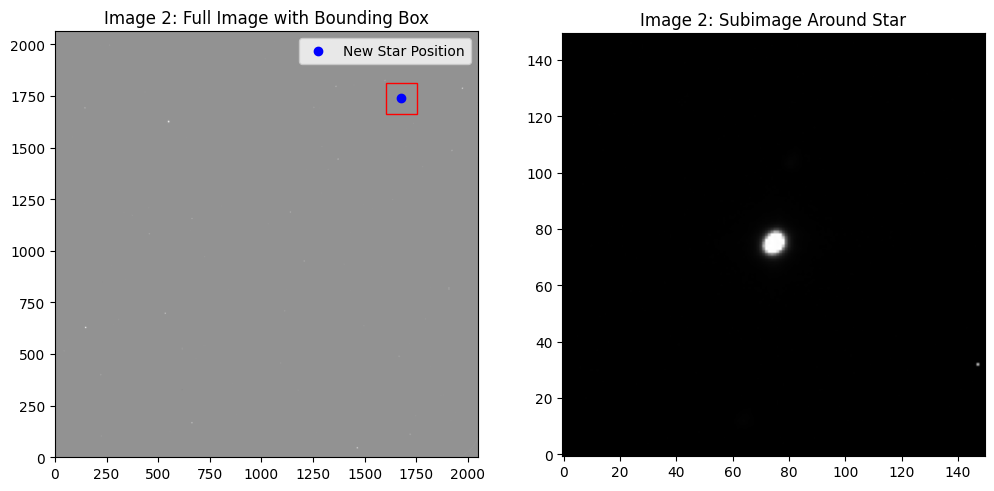

 Aligning image 2/32
    Offset : (1, 0)


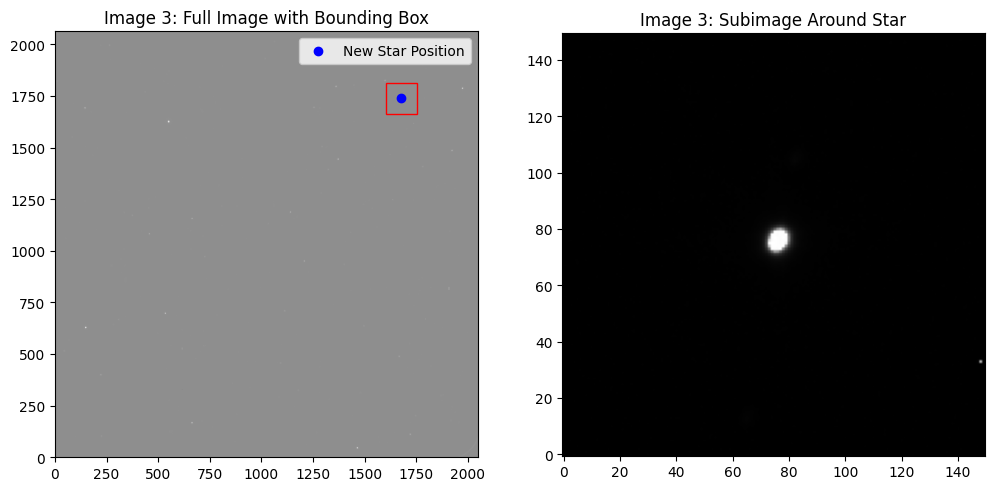

 Aligning image 3/32
    Offset : (0, 0)


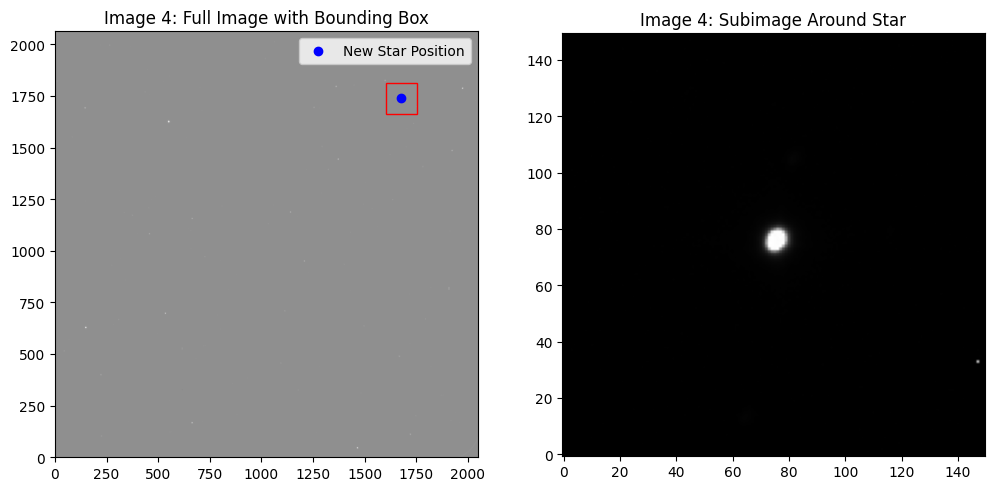

 Aligning image 4/32
    Offset : (0, 1)


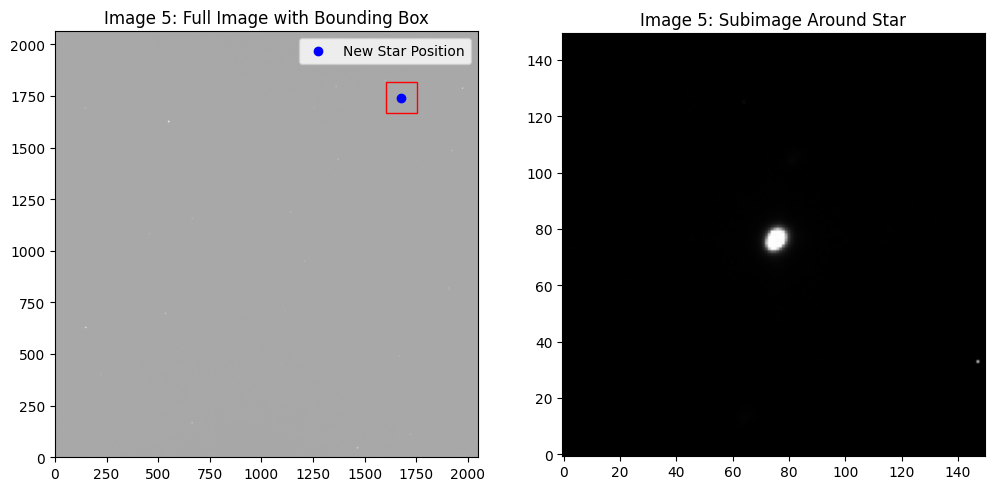

 Aligning image 5/32
    Offset : (0, 0)


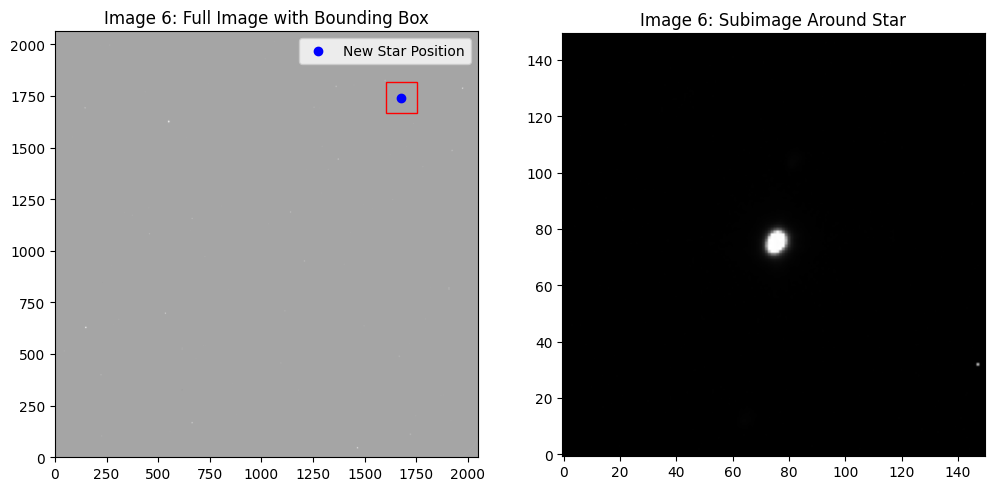

 Aligning image 6/32
    Offset : (-72, -5)


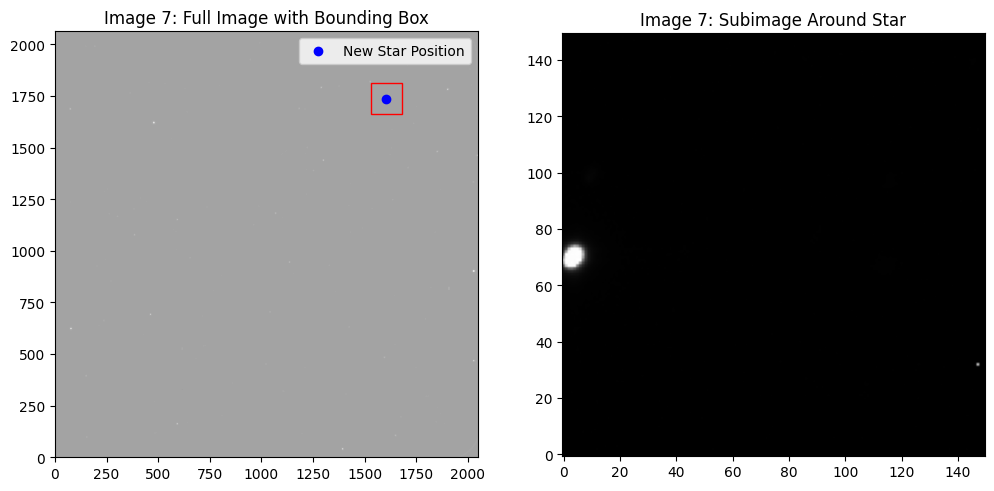

 Aligning image 7/32
    Offset : (0, 0)


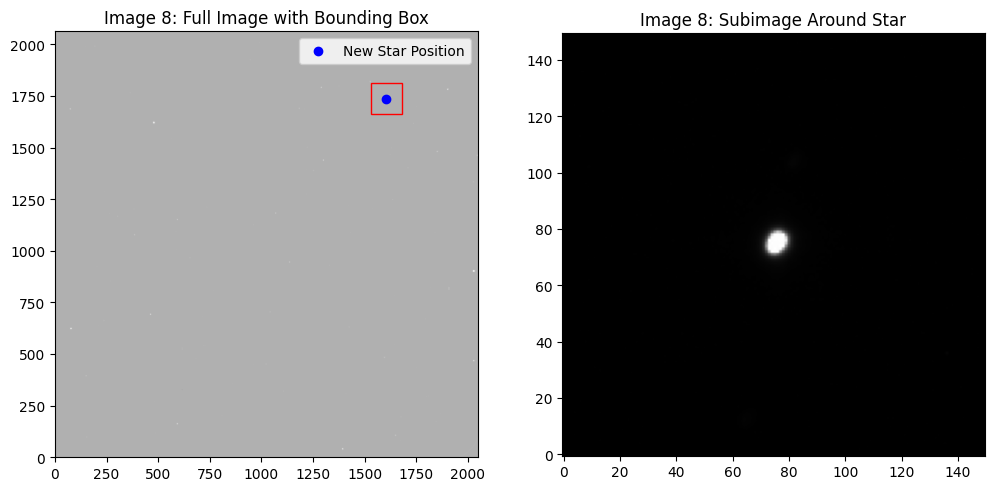

 Aligning image 8/32
    Offset : (0, 0)


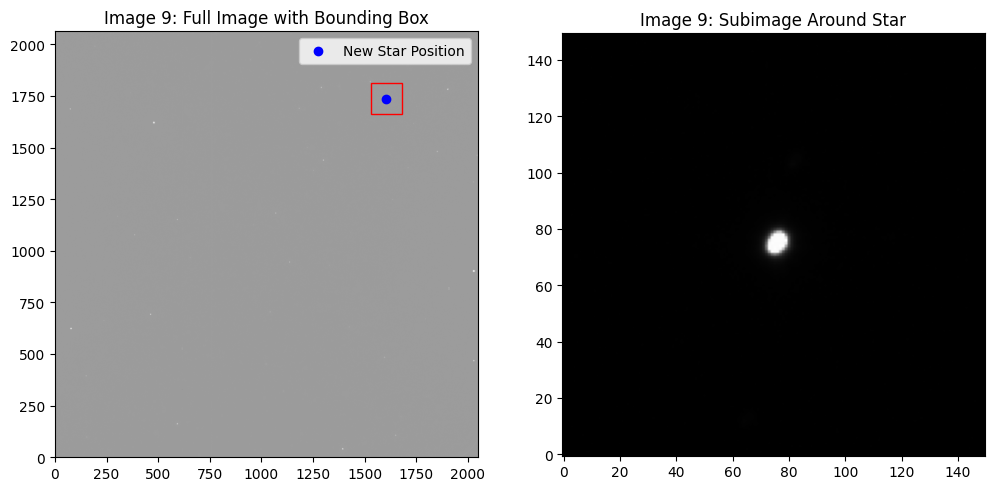

 Aligning image 9/32
    Offset : (1, 0)


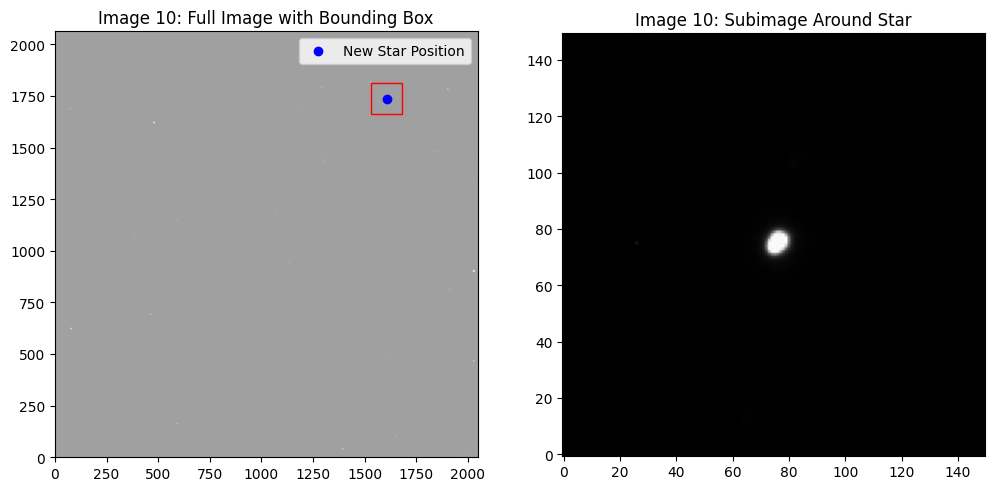

 Aligning image 10/32
    Offset : (-5, 41)


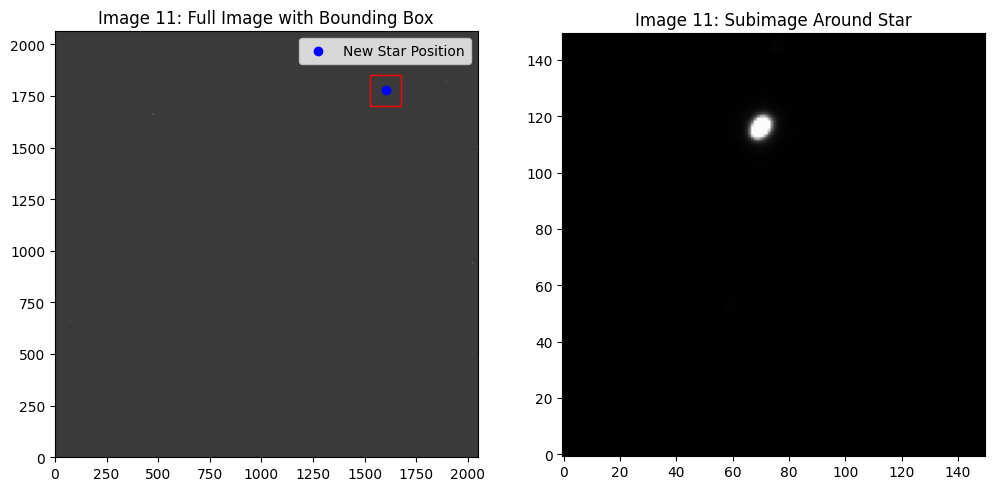

 Aligning image 11/32
    Offset : (0, 0)


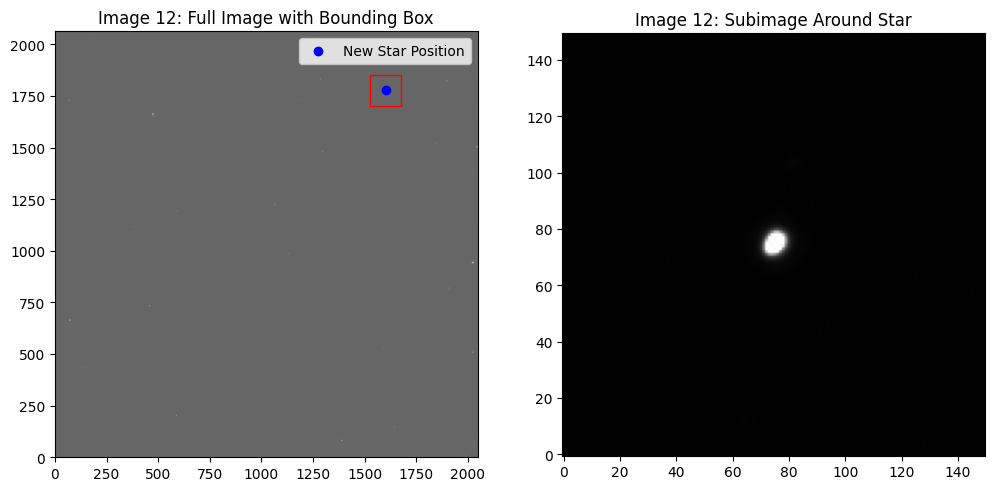

 Aligning image 12/32
    Offset : (44, -43)


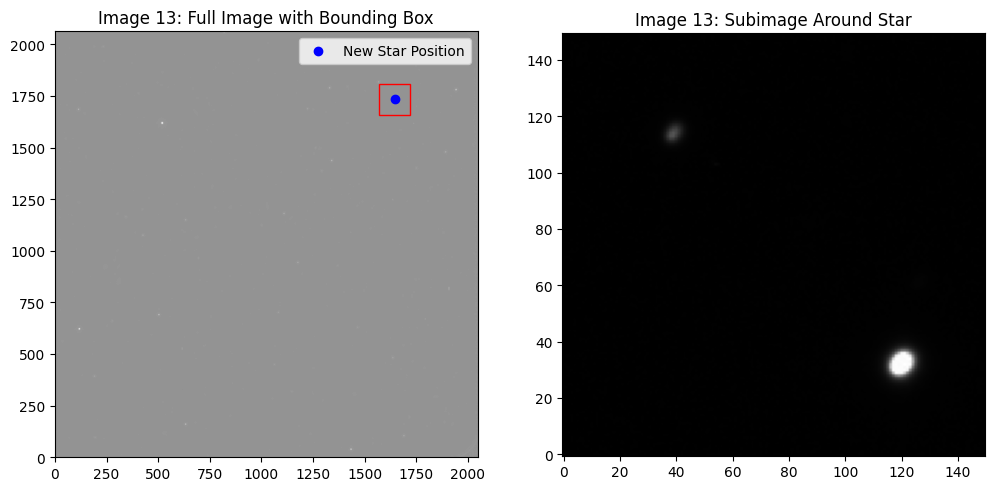

 Aligning image 13/32
    Offset : (1, 0)


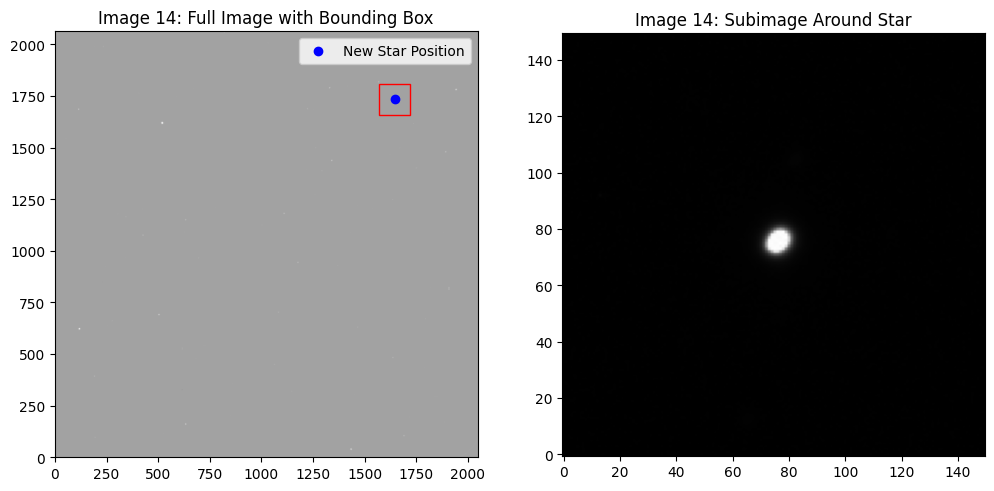

 Aligning image 14/32
    Offset : (0, 0)


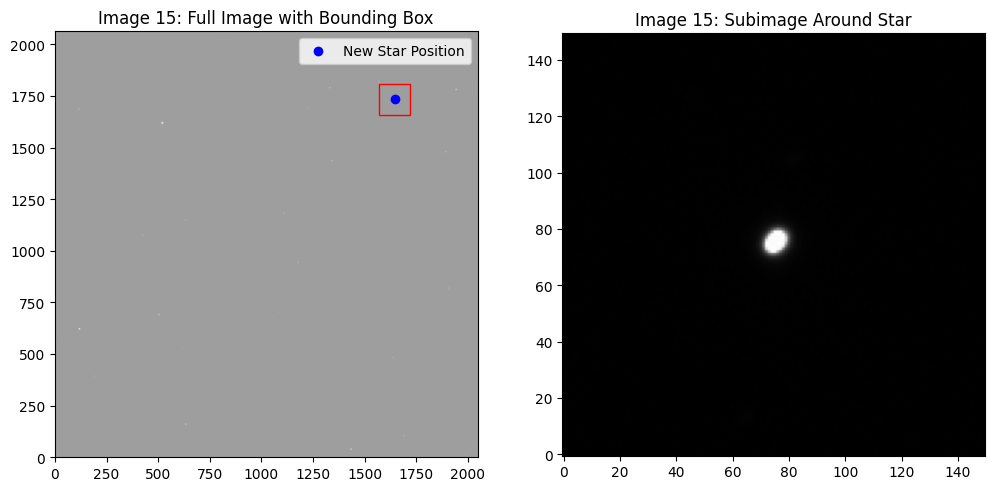

 Aligning image 15/32
    Offset : (0, 0)


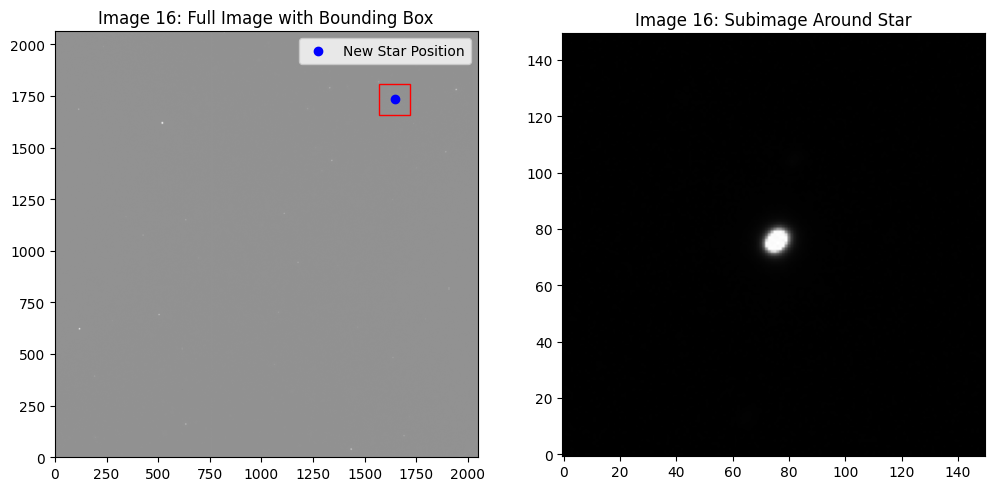

 Aligning image 16/32
    Offset : (2, -41)


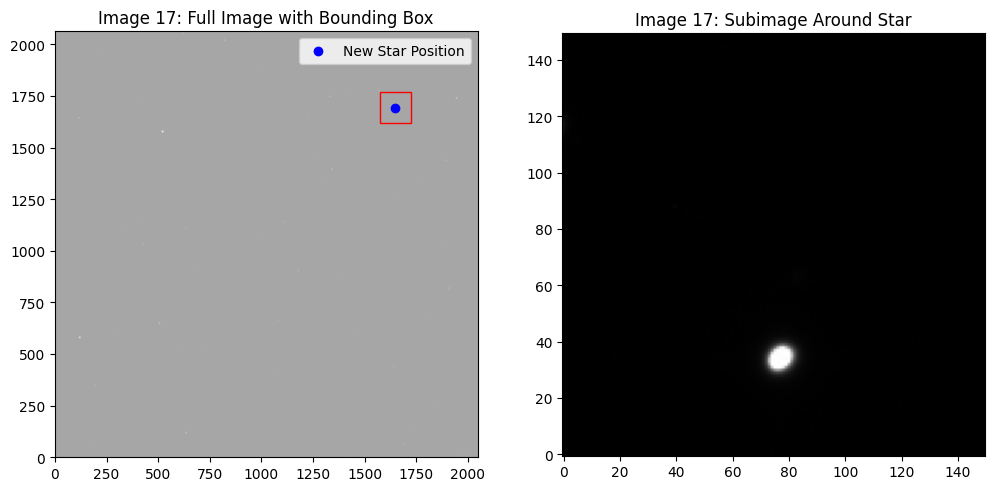

 Aligning image 17/32
    Offset : (0, -1)


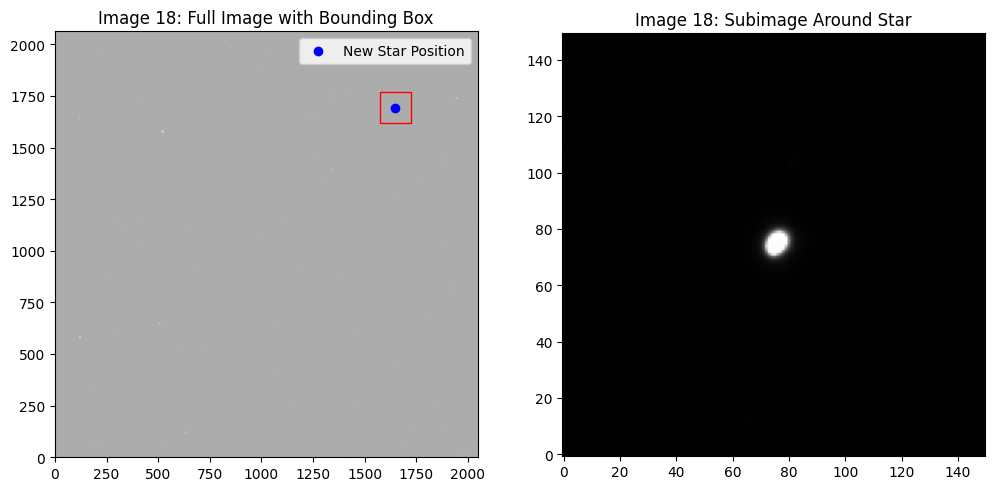

 Aligning image 18/32
    Offset : (-34, 2)


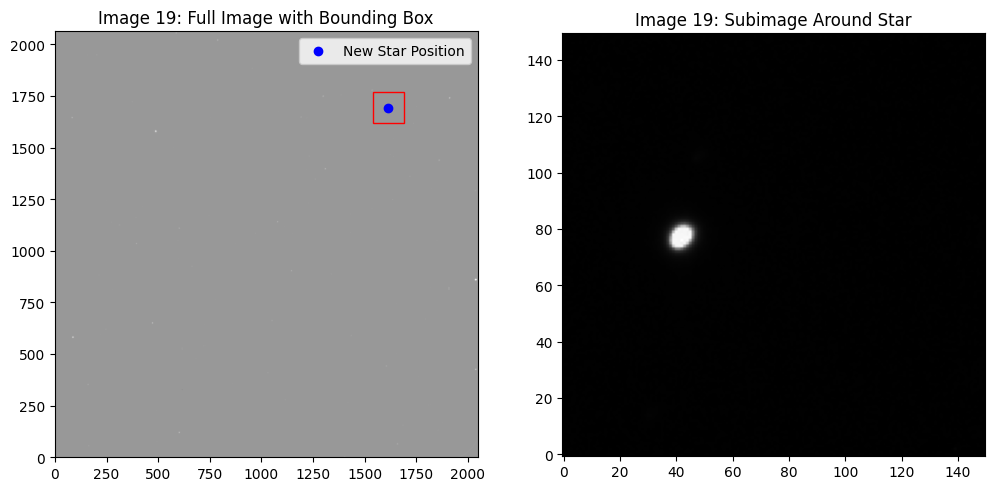

 Aligning image 19/32
    Offset : (1, 0)


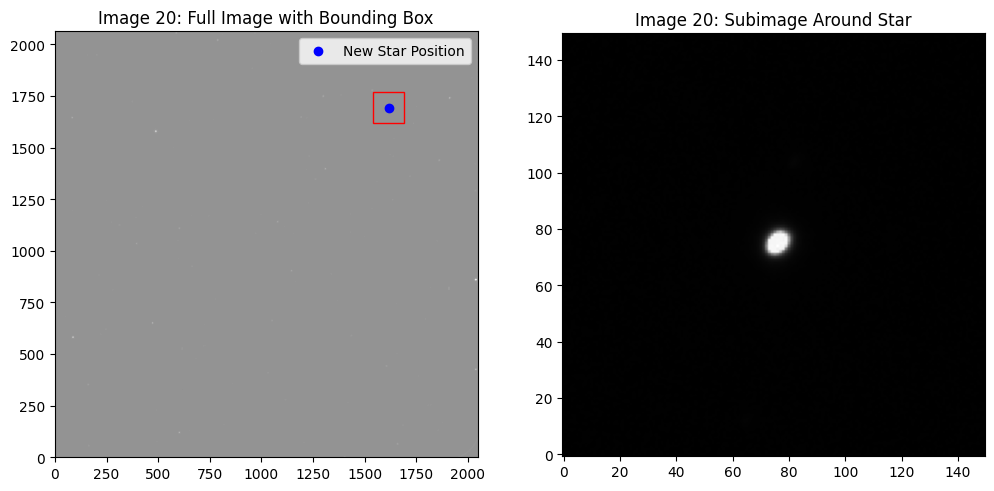

 Aligning image 20/32
    Offset : (14, 64)


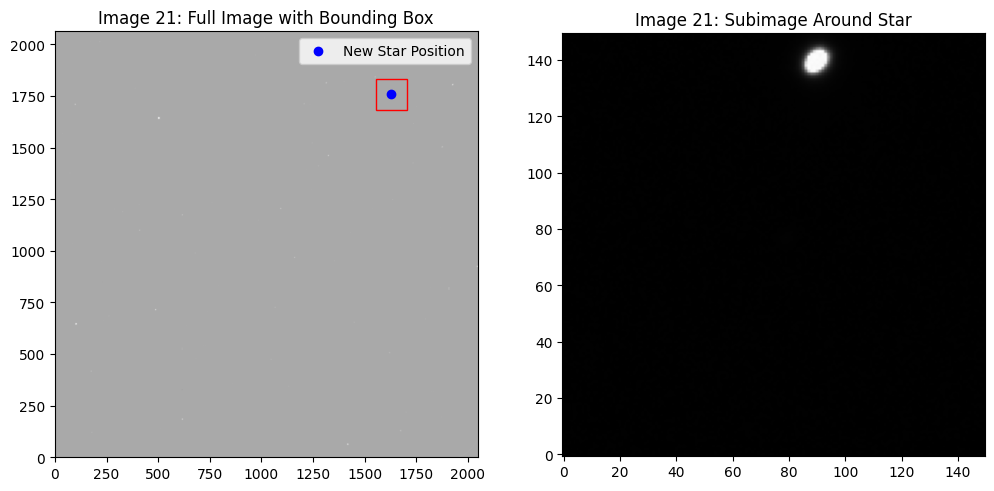

 Aligning image 21/32
    Offset : (0, 0)


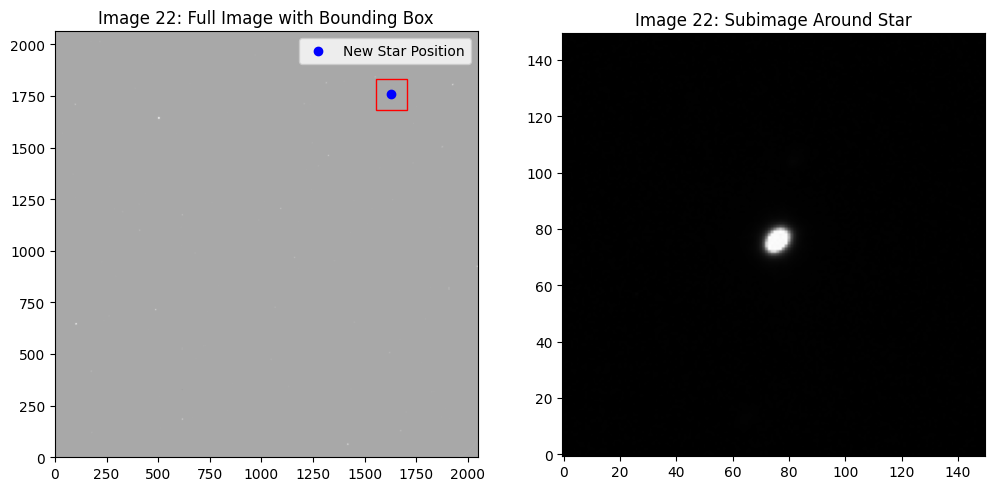

 Aligning image 22/32
    Offset : (0, 0)


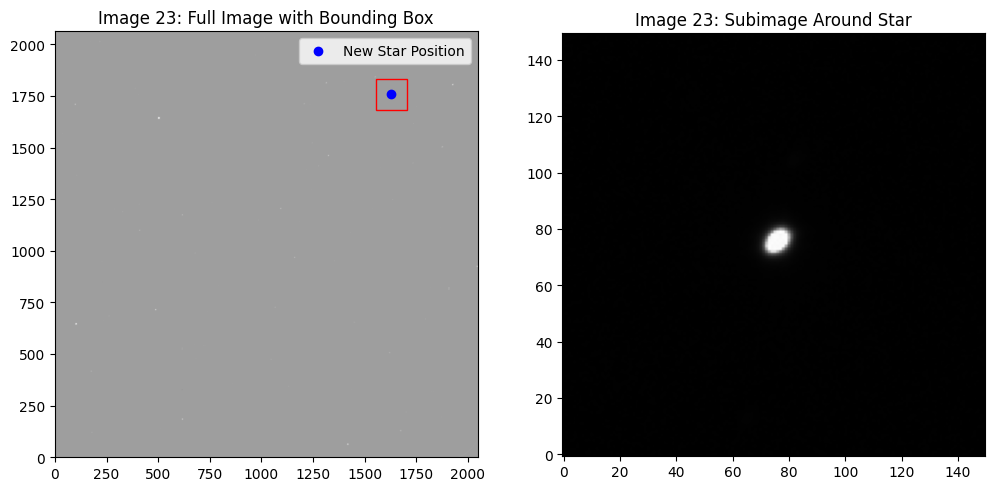

 Aligning image 23/32
    Offset : (1, 0)


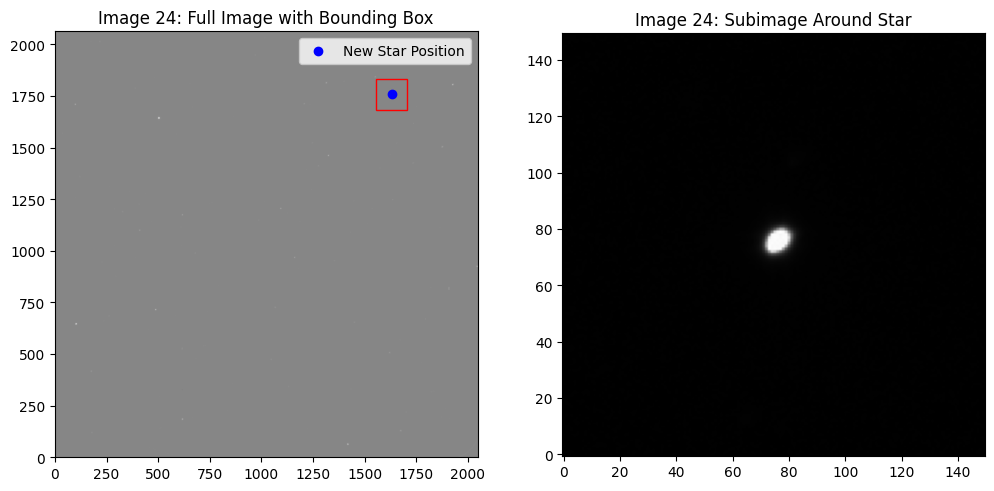

 Aligning image 24/32
    Offset : (0, 0)


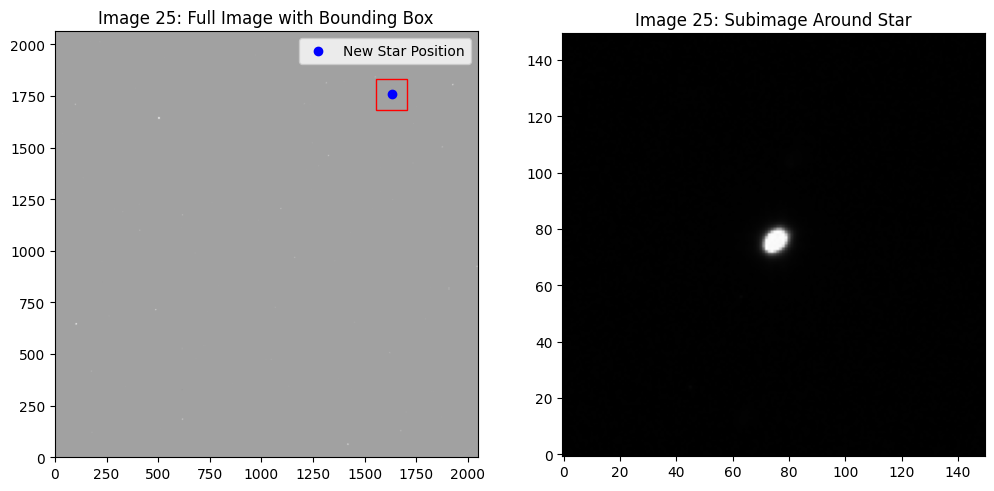

 Aligning image 25/32
    Offset : (-32, -24)


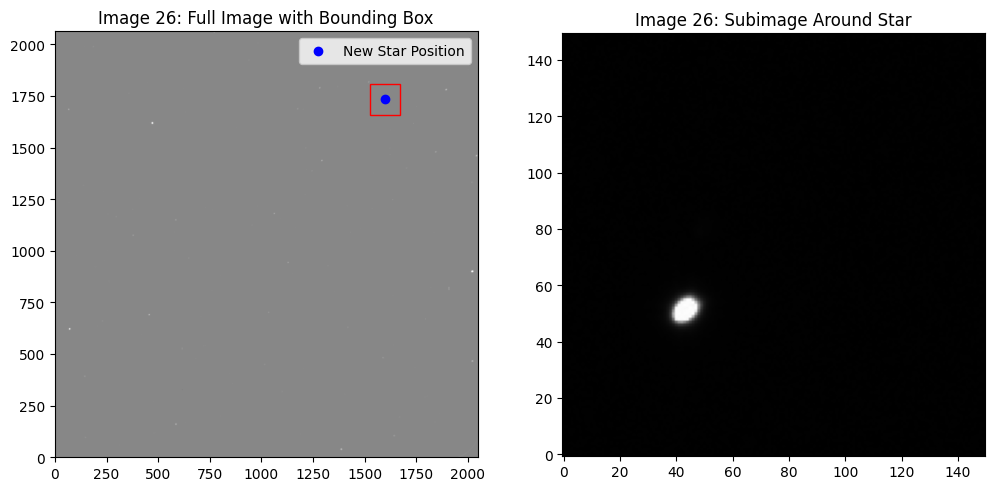

 Aligning image 26/32
    Offset : (0, 0)


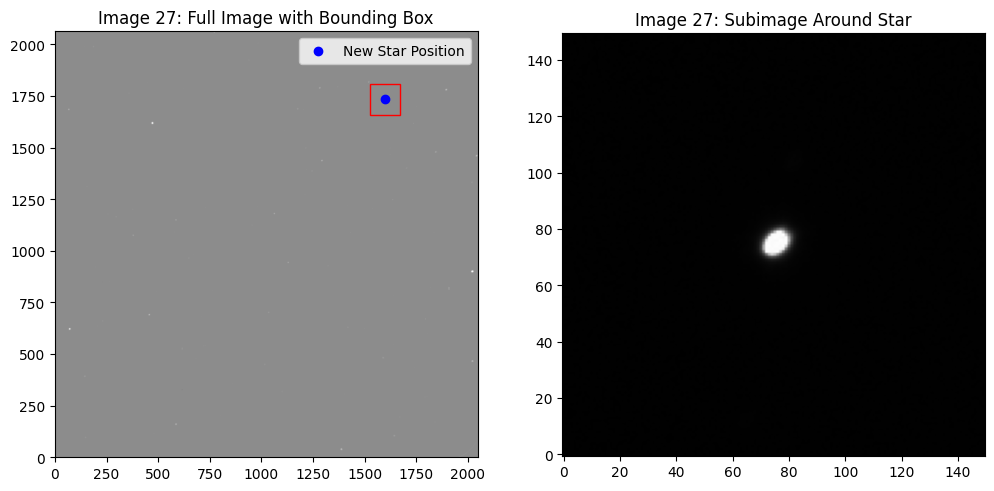

 Aligning image 27/32
    Offset : (12, 21)


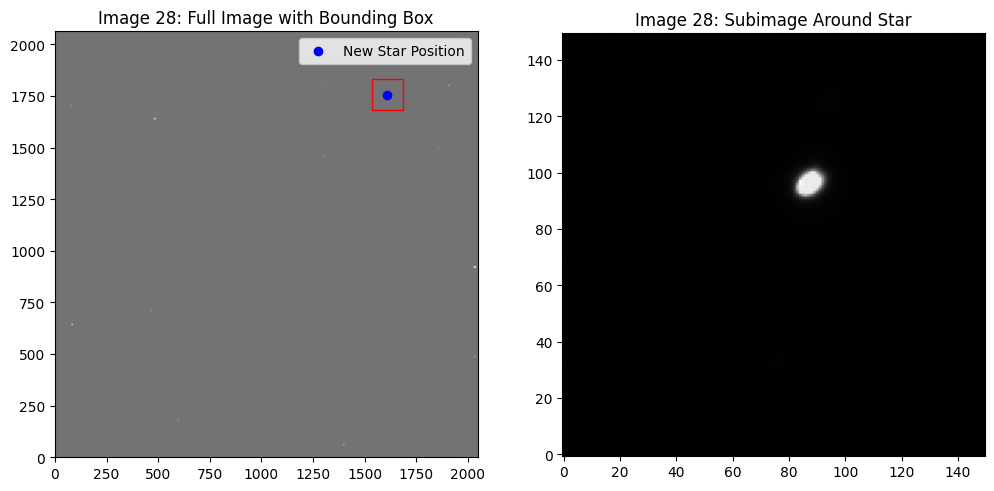

 Aligning image 28/32
    Offset : (0, -1)


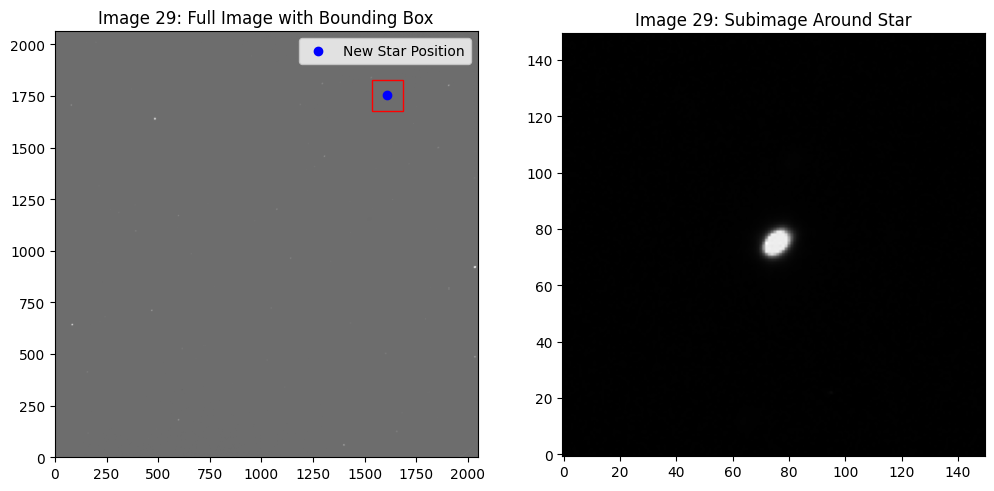

 Aligning image 29/32
    Offset : (-27, -18)


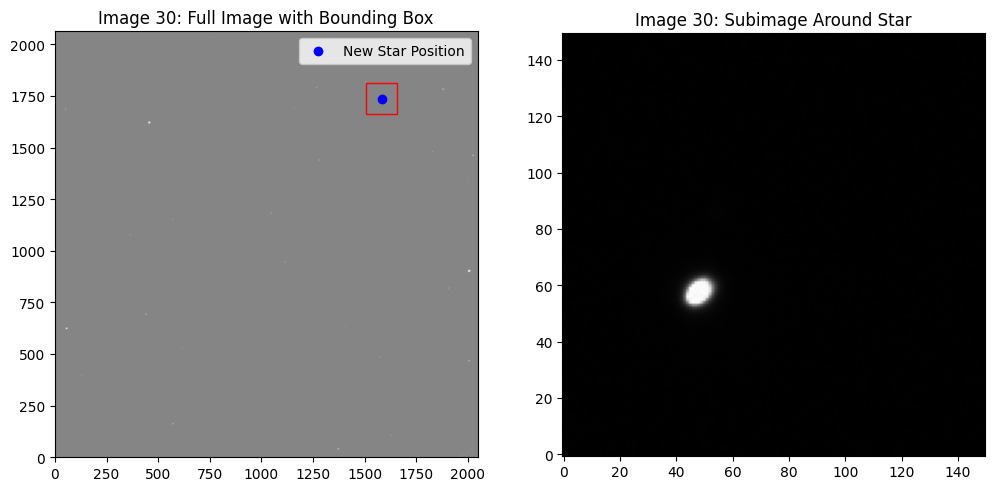

 Aligning image 30/32
    Offset : (-1, 0)


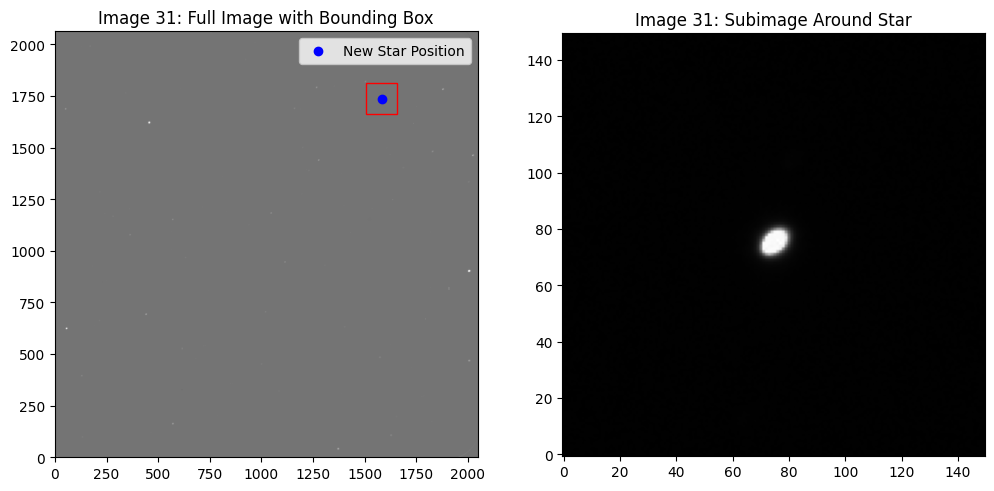

 Aligning image 31/32
    Offset : (1, 0)


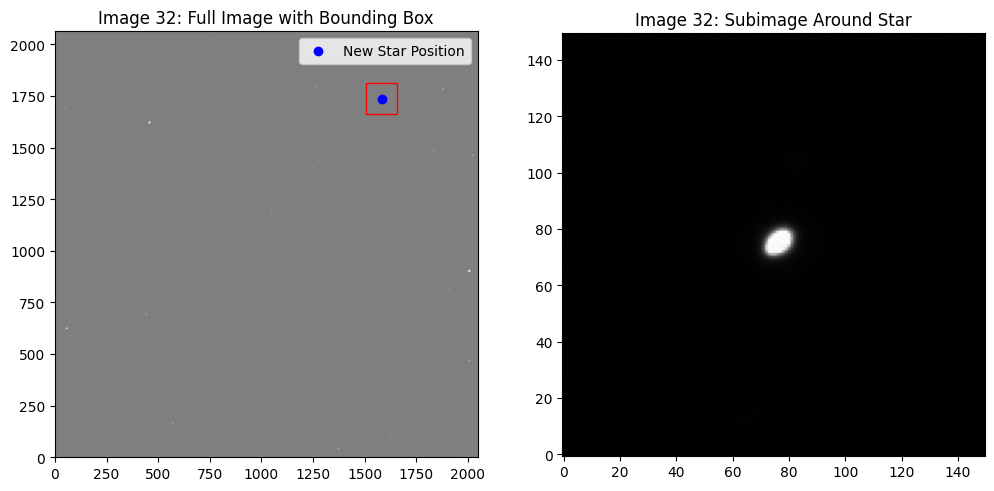

[(0, 0), (-1, -1), (0, -1), (0, -1), (0, 0), (0, 0), (-72, -5), (-72, -5), (-72, -5), (-71, -5), (-76, 36), (-76, 36), (-32, -7), (-31, -7), (-31, -7), (-31, -7), (-29, -48), (-29, -49), (-63, -47), (-62, -47), (-48, 17), (-48, 17), (-48, 17), (-47, 17), (-47, 17), (-79, -7), (-79, -7), (-67, 14), (-67, 13), (-94, -5), (-95, -5), (-94, -5)]


In [6]:
# List of files
Ns = [
    "0096",
    "0098",
    "0100",
    "0102",
    "0104",
    "0106",
    "0108",
    "0110",
    "0112",
    "0114",
    "0116",
    "0118",
    "0123",
    "0125",
    "0127",
    "0129",
    "0131",
    "0133",
    "0135",
    "0137",
    "0144",
    "0146",
    "0148",
    "0150",
    "0152",
    "0156",
    "0158",
    "0163",
    "0165",
    "0167",
    "0169",
    "0171"
    ]
files = [
    f'data/8_Oct/td10r_n2_{i}.fits' for i in Ns
]

print(files)
# Get array of offsets

Ref_star = (1678, 1741)
bounding = 75

relative_offsets = CreateOffsetArray(files, Ref_star, bounding, Debug=True, Verbose=True)


# Compute the absolute offsets
absolute_offsets = compute_absolute_offsets(relative_offsets)

print(absolute_offsets)

absolute offset of the last frame : (-94, -5)


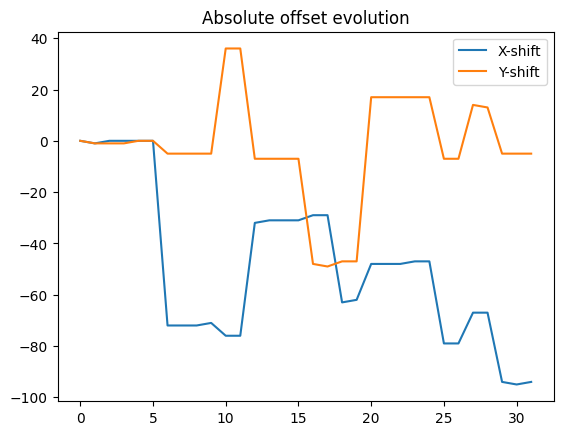

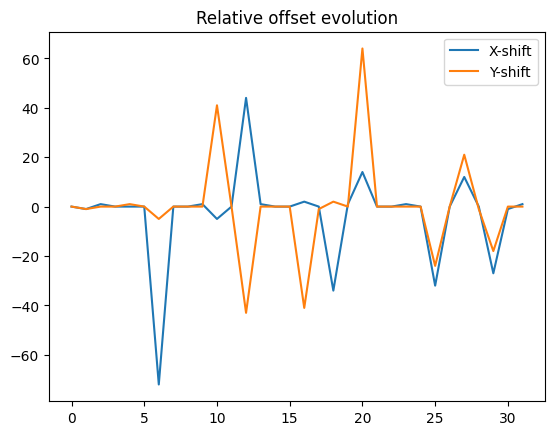

In [7]:
print(f'absolute offset of the last frame : {absolute_offsets[-1]}')

plt.plot([i for i in range(len(absolute_offsets))],[i[0] for i in absolute_offsets], label="X-shift")
plt.plot([i for i in range(len(absolute_offsets))],[i[1] for i in absolute_offsets], label="Y-shift")
plt.legend()
plt.title("Absolute offset evolution")
plt.show()

plt.plot([i for i in range(len(relative_offsets))],[i[0] for i in relative_offsets], label="X-shift")
plt.plot([i for i in range(len(relative_offsets))],[i[1] for i in relative_offsets], label="Y-shift")
plt.legend()
plt.title("Relative offset evolution")
plt.show()

The above part computes the relative and absolute offsets of each images. Now we will use the provided code to compute the mag.

manual data 8_Oct : 
```
96 : (1150, 1156) = start
98 : (1157, 1153)
100: (1154, 1156)

169: (1169, 1106)
171: (1172, 1104)  =>  (1266, 1109) = end
```

Using last image offset from first image we get the positions for the first and last frame.

In [8]:
def PositionInterpolation( start, end, sample_positions):
        # Extract starting and ending coordinates
    x_start, y_start = start
    x_end, y_end = end
    
    # Compute the step size for each frame (linear interpolation)
    x_step = (x_end - x_start) / (sample_positions - 1)
    y_step = (y_end - y_start) / (sample_positions - 1)
    
    # Generate the positions for each frame
    positions = [(x_start + i * x_step, y_start + i * y_step) for i in range(sample_positions)]
    
    return positions

Filename: data/8_Oct/td10r_n2_0096.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.0979167
exposition :  180.0  secs
resultats centroid =19.476 ,19.764
 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ------------------ ---------------- ------------
  1 19.476339702360754 19.7642394728676    116672.46

Sum_target_raw=116672.458

 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ------------------ ---------------- ------------
  1 19.476339702360754 19.7642394728676    260465.87

Sky_background=260465.874

Target flux without sky=14927.976

instrumental magnitude=-10.435

260465.87415764673


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

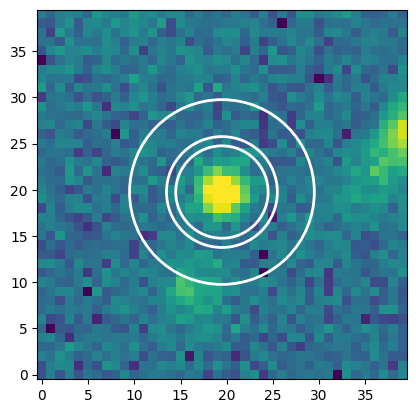

{'mjd': 52190.0979167, 'exptime': 180.0, 'magnitude': -10.435002295671122, 'sky': -9.023927141942265}
Filename: data/8_Oct/td10r_n2_0098.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1048958
exposition :  180.0  secs
resultats centroid =20.065 ,21.803
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 20.064522270566094 21.803194306512513    112301.71

Sum_target_raw=112301.710

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 20.064522270566094 21.803194306512513    249718.11

Sky_background=249718.112

Target flux without sky=14755.572

instrumental magnitude=-10.422

249718.11246738373


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

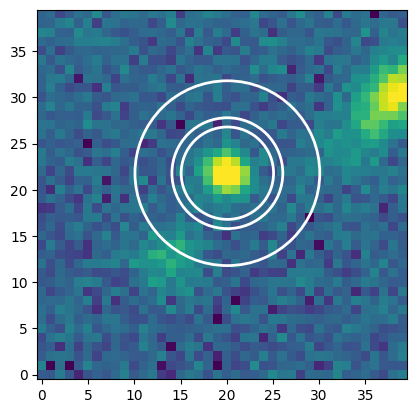

{'mjd': 52190.1048958, 'exptime': 180.0, 'magnitude': -10.422390139195212, 'sky': -8.978175174015961}
Filename: data/8_Oct/td10r_n2_0100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1122569
exposition :  180.0  secs
resultats centroid =19.795 ,21.275
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 19.794996615429366 21.274703976069123    118772.27

Sum_target_raw=118772.273

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 19.794996615429366 21.274703976069123    265648.48

Sky_background=265648.476

Target flux without sky=15003.337

instrumental magnitude=-10.440

265648.4764255941


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

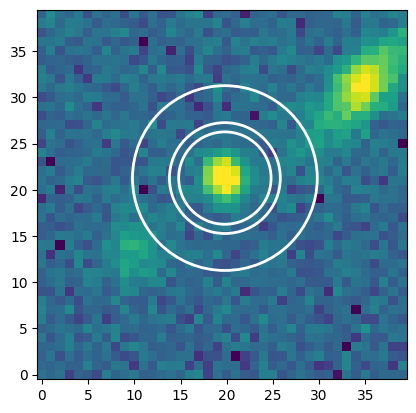

{'mjd': 52190.1122569, 'exptime': 180.0, 'magnitude': -10.440469674293615, 'sky': -9.045318388646816}
Filename: data/8_Oct/td10r_n2_0102.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1189468
exposition :  180.0  secs
resultats centroid =19.082 ,22.088
 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 19.08156593978875 22.08774908642945    116122.83

Sum_target_raw=116122.831

 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 19.08156593978875 22.08774908642945    256897.01

Sky_background=256897.013

Target flux without sky=15772.436

instrumental magnitude=-10.495

256897.01256404235


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

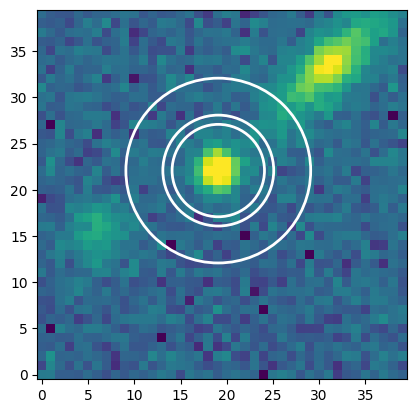

{'mjd': 52190.1189468, 'exptime': 180.0, 'magnitude': -10.49474692528906, 'sky': -9.008947699835232}
Filename: data/8_Oct/td10r_n2_0104.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1262153
exposition :  180.0  secs
resultats centroid =18.119 ,20.910
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.119427867417233 20.909879171037765    113454.27

Sum_target_raw=113454.269

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.119427867417233 20.909879171037765       251961

Sky_background=251961.000

Target flux without sky=15032.004

instrumental magnitude=-10.443

251960.99969997263


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

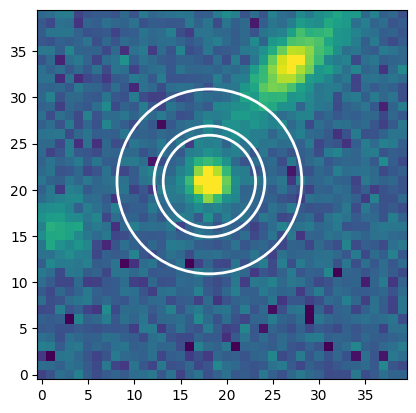

{'mjd': 52190.1262153, 'exptime': 180.0, 'magnitude': -10.442542203494995, 'sky': -8.987883372094455}
Filename: data/8_Oct/td10r_n2_0106.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1328935
exposition :  180.0  secs
resultats centroid =17.214 ,21.680
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 17.214376038171054 21.680234971904298     109232.3

Sum_target_raw=109232.302

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 17.214376038171054 21.680234971904298    240604.51

Sky_background=240604.514

Target flux without sky=15246.164

instrumental magnitude=-10.458

240604.51431195933


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

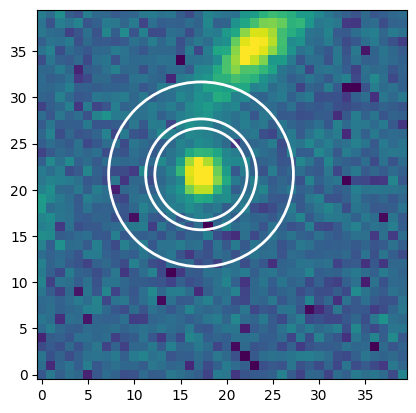

{'mjd': 52190.1328935, 'exptime': 180.0, 'magnitude': -10.45790145225974, 'sky': -8.937809493730033}
Filename: data/8_Oct/td10r_n2_0108.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1415046
exposition :  180.0  secs
resultats centroid =18.138 ,20.832
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.138140517411163 20.831699510601105    106666.99

Sum_target_raw=106666.988

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.138140517411163 20.831699510601105    235213.05

Sky_background=235213.046

Target flux without sky=14786.891

instrumental magnitude=-10.425

235213.04629870984


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

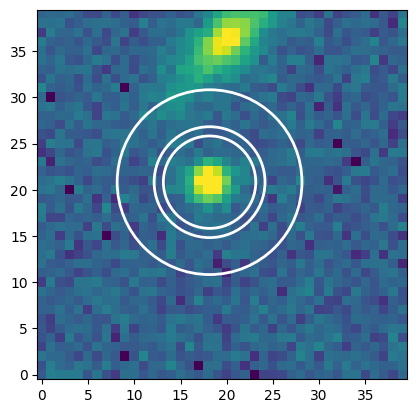

{'mjd': 52190.1415046, 'exptime': 180.0, 'magnitude': -10.424692214818341, 'sky': -8.91320358153526}
Filename: data/8_Oct/td10r_n2_0110.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1481829
exposition :  180.0  secs
resultats centroid =17.293 ,21.710
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 17.29337753131254 21.709795069731285    108570.96

Sum_target_raw=108570.959

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 17.29337753131254 21.709795069731285    239349.75

Sky_background=239349.750

Target flux without sky=15074.963

instrumental magnitude=-10.446

239349.7500904871


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

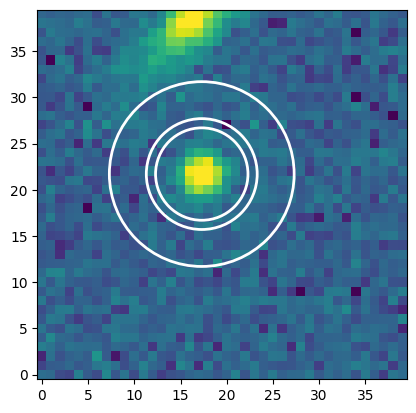

{'mjd': 52190.1481829, 'exptime': 180.0, 'magnitude': -10.44564064205822, 'sky': -8.932132510948485}
Filename: data/8_Oct/td10r_n2_0112.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1597454
exposition :  180.0  secs
resultats centroid =18.845 ,20.266
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 18.84504122689985 20.266405912923737    123306.39

Sum_target_raw=123306.393

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 18.84504122689985 20.266405912923737    277417.69

Sky_background=277417.691

Target flux without sky=14940.107

instrumental magnitude=-10.436

277417.6908966552


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

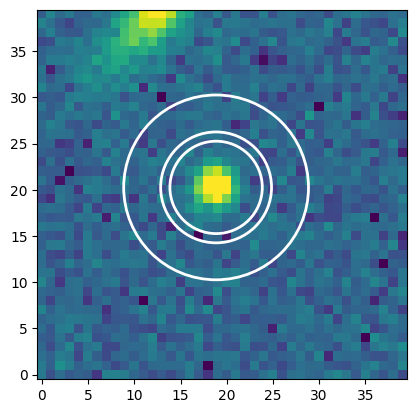

{'mjd': 52190.1597454, 'exptime': 180.0, 'magnitude': -10.435884271115327, 'sky': -9.092385446373516}
Filename: data/8_Oct/td10r_n2_0114.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1664236
exposition :  180.0  secs
resultats centroid =16.833 ,21.019
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.832745863348084 21.019164355128964    136748.57

Sum_target_raw=136748.573

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.832745863348084 21.019164355128964    311082.71

Sky_background=311082.708

Target flux without sky=15231.890

instrumental magnitude=-10.457

311082.70766226365


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

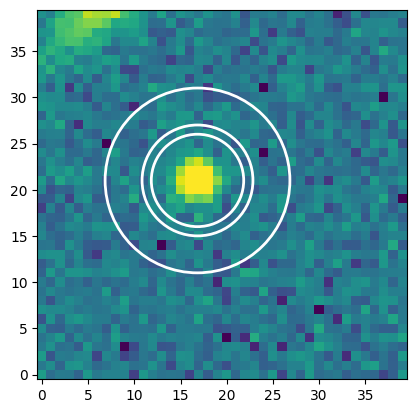

{'mjd': 52190.1664236, 'exptime': 180.0, 'magnitude': -10.45688450669263, 'sky': -9.216739741031386}
Filename: data/8_Oct/td10r_n2_0116.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1743171
exposition :  180.0  secs
resultats centroid =17.365 ,20.248
 id     xcenter           ycenter       aperture_sum
          pix               pix                     
--- ---------------- ------------------ ------------
  1 17.3653553715605 20.248445029203413    148158.97

Sum_target_raw=148158.972

 id     xcenter           ycenter       aperture_sum
          pix               pix                     
--- ---------------- ------------------ ------------
  1 17.3653553715605 20.248445029203413    336230.73

Sky_background=336230.728

Target flux without sky=16818.844

instrumental magnitude=-10.564

336230.7281040238


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

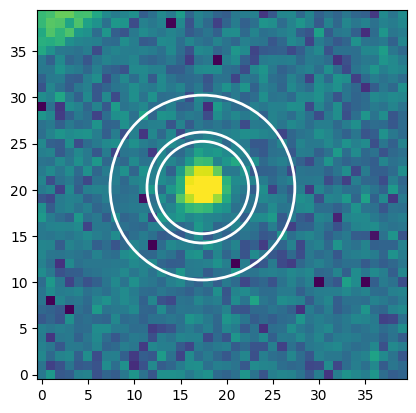

{'mjd': 52190.1743171, 'exptime': 180.0, 'magnitude': -10.564490371163771, 'sky': -9.301143567693298}
Filename: data/8_Oct/td10r_n2_0118.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1809954
exposition :  180.0  secs
resultats centroid =16.691 ,21.114
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.691219778479134 21.114069467783647    152882.97

Sum_target_raw=152882.969

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.691219778479134 21.114069467783647    348438.41

Sky_background=348438.414

Target flux without sky=16774.214

instrumental magnitude=-10.562

348438.41355698754


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

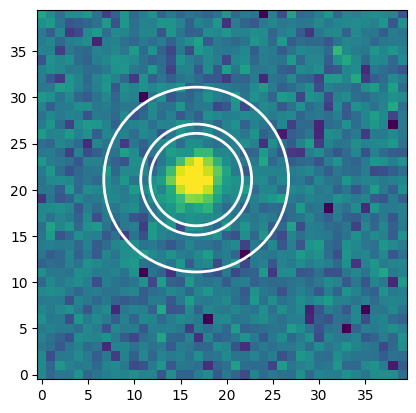

{'mjd': 52190.1809954, 'exptime': 180.0, 'magnitude': -10.561605440578338, 'sky': -9.339865134353797}
Filename: data/8_Oct/td10r_n2_0123.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.1953009
exposition :  180.0  secs
resultats centroid =19.941 ,19.871
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 19.940738645684515 19.87059787593498    161580.25

Sum_target_raw=161580.250

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 19.940738645684515 19.87059787593498    369853.41

Sky_background=369853.413

Target flux without sky=17106.261

instrumental magnitude=-10.583

369853.4133667045


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

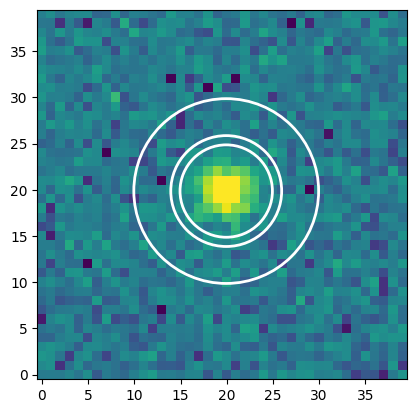

{'mjd': 52190.1953009, 'exptime': 180.0, 'magnitude': -10.58288772818576, 'sky': -9.404624142910102}
Filename: data/8_Oct/td10r_n2_0125.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2022222
exposition :  180.0  secs
resultats centroid =18.305 ,20.787
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.305434912100345 20.786955814326525    162634.61

Sum_target_raw=162634.607

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.305434912100345 20.786955814326525    371767.89

Sky_background=371767.895

Target flux without sky=17412.773

instrumental magnitude=-10.602

371767.89467756846


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

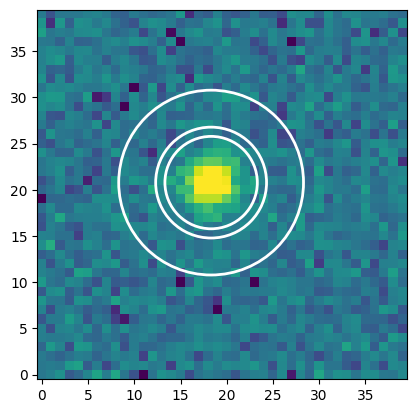

{'mjd': 52190.2022222, 'exptime': 180.0, 'magnitude': -10.602169865306406, 'sky': -9.410229770114585}
Filename: data/8_Oct/td10r_n2_0127.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2094792
exposition :  180.0  secs
resultats centroid =18.671 ,20.348
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 18.671094708320222 20.34774433366595    165682.21

Sum_target_raw=165682.207

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 18.671094708320222 20.34774433366595    374693.46

Sky_background=374693.459

Target flux without sky=19317.575

instrumental magnitude=-10.715

374693.4588772933


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

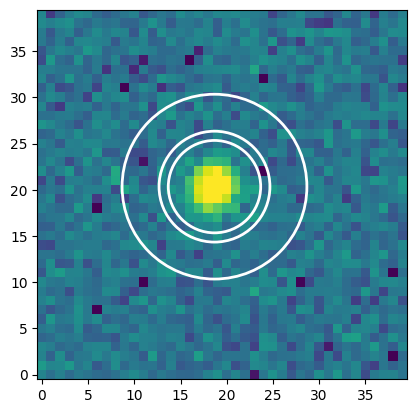

{'mjd': 52190.2094792, 'exptime': 180.0, 'magnitude': -10.71488150686855, 'sky': -9.418740343956436}
Filename: data/8_Oct/td10r_n2_0129.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.216169
exposition :  180.0  secs
resultats centroid =17.986 ,21.401
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 17.985530640215828 21.40056452570108    168104.49

Sum_target_raw=168104.492

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 17.985530640215828 21.40056452570108    383450.78

Sky_background=383450.784

Target flux without sky=18319.030

instrumental magnitude=-10.657

383450.7835106265


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

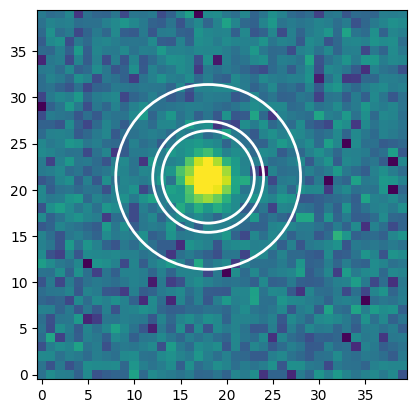

{'mjd': 52190.216169, 'exptime': 180.0, 'magnitude': -10.657256162265165, 'sky': -9.443824138807434}
Filename: data/8_Oct/td10r_n2_0131.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2235532
exposition :  180.0  secs
resultats centroid =16.555 ,20.333
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.555378601009714 20.333277159909255    174497.31

Sum_target_raw=174497.314

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.555378601009714 20.333277159909255    397121.74

Sky_background=397121.745

Target flux without sky=19371.632

instrumental magnitude=-10.718

397121.7445353426


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

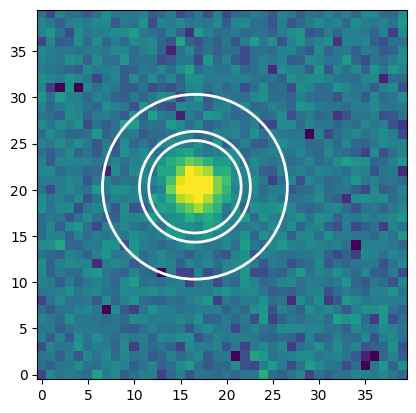

{'mjd': 52190.2235532, 'exptime': 180.0, 'magnitude': -10.71791553048203, 'sky': -9.481859234180499}
Filename: data/8_Oct/td10r_n2_0133.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2302431
exposition :  180.0  secs
resultats centroid =16.321 ,21.654
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.321436647912158 21.653512310115282    177403.13

Sum_target_raw=177403.125

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.321436647912158 21.653512310115282    404448.23

Sky_background=404448.233

Target flux without sky=19415.534

instrumental magnitude=-10.720

404448.23333365587


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

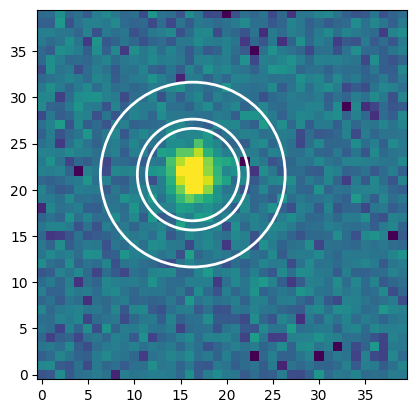

{'mjd': 52190.2302431, 'exptime': 180.0, 'magnitude': -10.720373342406573, 'sky': -9.501707421837773}
Filename: data/8_Oct/td10r_n2_0135.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2377778
exposition :  180.0  secs
resultats centroid =16.937 ,20.377
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.937255434687234 20.377016001076356    184584.62

Sum_target_raw=184584.617

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.937255434687234 20.377016001076356    419166.52

Sky_background=419166.523

Target flux without sky=20847.694

instrumental magnitude=-10.798

419166.5228888702


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

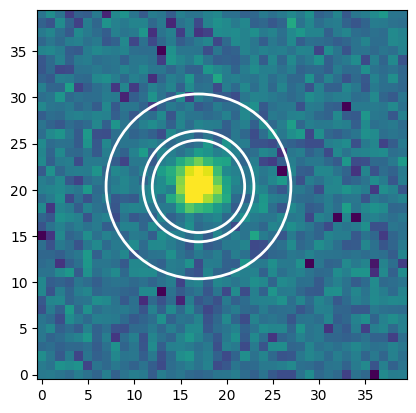

{'mjd': 52190.2377778, 'exptime': 180.0, 'magnitude': -10.79764507068461, 'sky': -9.540516540144054}
Filename: data/8_Oct/td10r_n2_0137.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2444676
exposition :  180.0  secs
resultats centroid =15.124 ,21.262
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 15.124420236274535 21.261816949045258    187716.94

Sum_target_raw=187716.944

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 15.124420236274535 21.261816949045258    425791.87

Sky_background=425791.868

Target flux without sky=21391.996

instrumental magnitude=-10.826

425791.86793180153


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

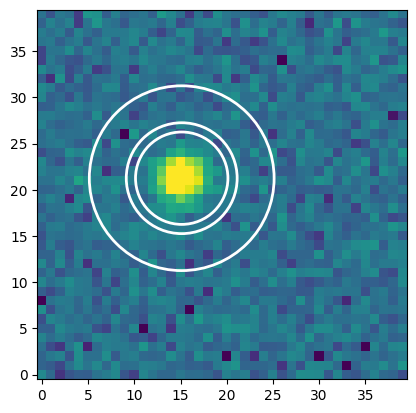

{'mjd': 52190.2444676, 'exptime': 180.0, 'magnitude': -10.825628252235935, 'sky': -9.557543471851522}
Filename: data/8_Oct/td10r_n2_0144.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2606944
exposition :  180.0  secs
resultats centroid =19.226 ,19.700
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 19.22631513568915 19.700376495845894    194160.92

Sum_target_raw=194160.916

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 19.22631513568915 19.700376495845894    442830.63

Sky_background=442830.629

Target flux without sky=21180.201

instrumental magnitude=-10.815

442830.6294439676


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

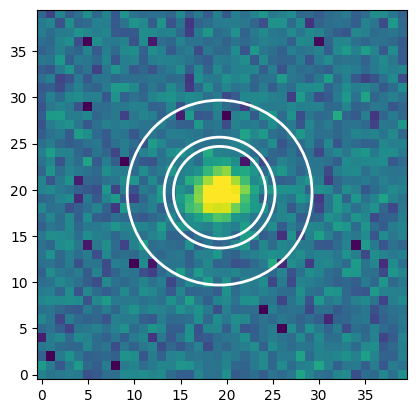

{'mjd': 52190.2606944, 'exptime': 180.0, 'magnitude': -10.814825207369525, 'sky': -9.600144195706324}
Filename: data/8_Oct/td10r_n2_0146.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2675347
exposition :  180.0  secs
resultats centroid =18.378 ,20.454
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 18.37849463491224 20.454240983916144    196946.18

Sum_target_raw=196946.179

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 18.37849463491224 20.454240983916144    446613.61

Sky_background=446613.606

Target flux without sky=22487.739

instrumental magnitude=-10.880

446613.6058535322


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

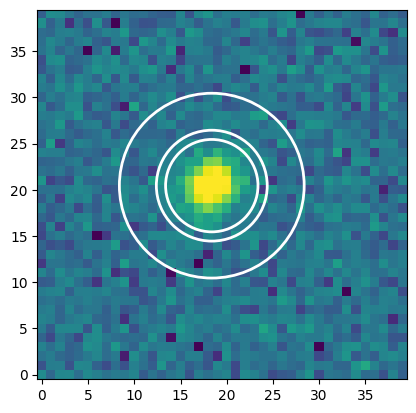

{'mjd': 52190.2675347, 'exptime': 180.0, 'magnitude': -10.879864476461558, 'sky': -9.609379938777078}
Filename: data/8_Oct/td10r_n2_0148.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2748032
exposition :  180.0  secs
resultats centroid =18.834 ,19.957
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 18.834121354187914 19.95683081879661    200017.21

Sum_target_raw=200017.214

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 18.834121354187914 19.95683081879661    454276.54

Sky_background=454276.543

Target flux without sky=22565.440

instrumental magnitude=-10.884

454276.54284250375


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

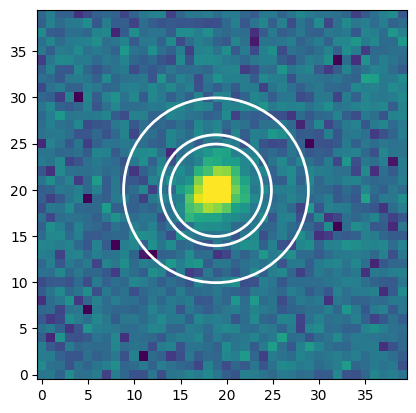

{'mjd': 52190.2748032, 'exptime': 180.0, 'magnitude': -10.883609512859167, 'sky': -9.627850845129483}
Filename: data/8_Oct/td10r_n2_0150.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2814931
exposition :  180.0  secs
resultats centroid =16.867 ,20.762
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.867275355453177 20.762095563398802    205748.49

Sum_target_raw=205748.486

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.867275355453177 20.762095563398802    467737.94

Sky_background=467737.943

Target flux without sky=23038.351

instrumental magnitude=-10.906

467737.94312088867


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

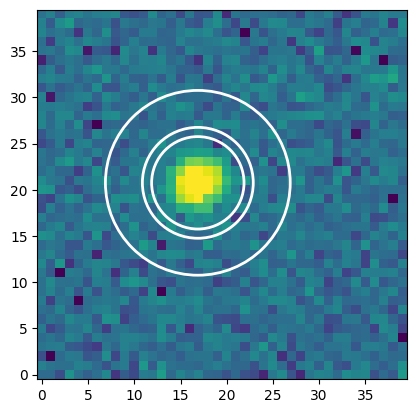

{'mjd': 52190.2814931, 'exptime': 180.0, 'magnitude': -10.906128500021898, 'sky': -9.659556568813246}
Filename: data/8_Oct/td10r_n2_0152.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.2887731
exposition :  180.0  secs
resultats centroid =16.245 ,20.213
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.244841200212782 20.212603059771553    208768.42

Sum_target_raw=208768.416

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.244841200212782 20.212603059771553    478302.05

Sky_background=478302.048

Target flux without sky=21931.679

instrumental magnitude=-10.853

478302.04750123824


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

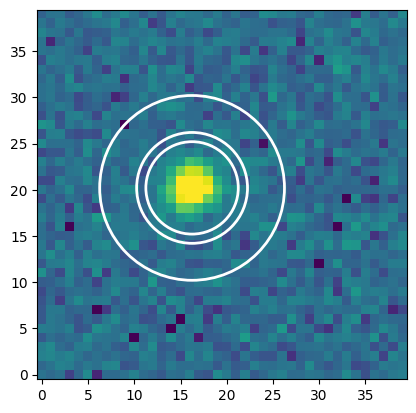

{'mjd': 52190.2887731, 'exptime': 180.0, 'magnitude': -10.852679679759243, 'sky': -9.683805665017527}
Filename: data/8_Oct/td10r_n2_0156.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.3034259
exposition :  180.0  secs
resultats centroid =18.988 ,18.971
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.987578048010338 18.971129609585223    224405.59

Sum_target_raw=224405.590

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.987578048010338 18.971129609585223    514504.56

Sky_background=514504.558

Target flux without sky=23427.247

instrumental magnitude=-10.924

514504.5584437264


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

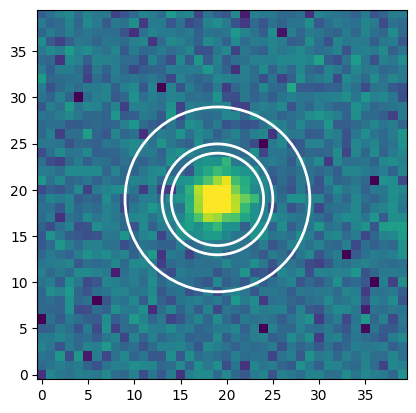

{'mjd': 52190.3034259, 'exptime': 180.0, 'magnitude': -10.924303131641684, 'sky': -9.763023132311128}
Filename: data/8_Oct/td10r_n2_0158.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.3101157
exposition :  180.0  secs
resultats centroid =19.189 ,18.568
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 19.18883098862215 18.567726701410834     229801.6

Sum_target_raw=229801.599

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 19.18883098862215 18.567726701410834    528079.26

Sky_background=528079.261

Target flux without sky=23520.638

instrumental magnitude=-10.929

528079.2606519135


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

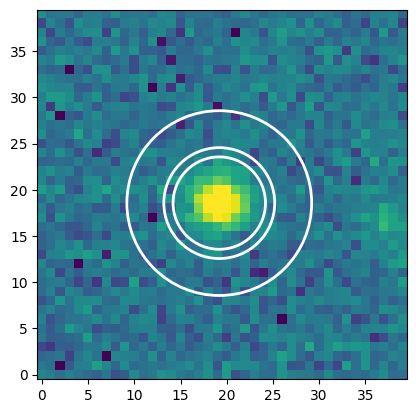

{'mjd': 52190.3101157, 'exptime': 180.0, 'magnitude': -10.928622757053507, 'sky': -9.791297844293158}
Filename: data/8_Oct/td10r_n2_0163.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.3232639
exposition :  180.0  secs
resultats centroid =20.949 ,18.106
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 20.949427995662077 18.10602613505148    235907.07

Sum_target_raw=235907.071

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 20.949427995662077 18.10602613505148    552048.51

Sky_background=552048.510

Target flux without sky=20263.122

instrumental magnitude=-10.767

552048.5099730963


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

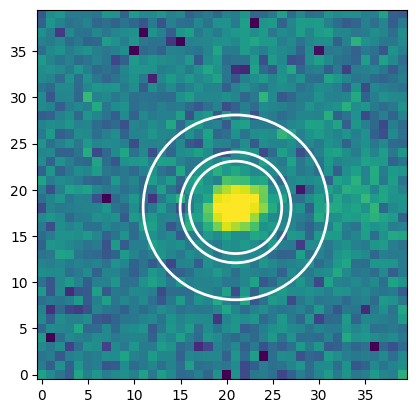

{'mjd': 52190.3232639, 'exptime': 180.0, 'magnitude': -10.766765886043368, 'sky': -9.83949317008779}
Filename: data/8_Oct/td10r_n2_0165.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.3303009
exposition :  180.0  secs
resultats centroid =20.250 ,18.864
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 20.24979712909016 18.863776205121916    243224.51

Sum_target_raw=243224.508

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 20.24979712909016 18.863776205121916    568657.09

Sky_background=568657.091

Target flux without sky=21092.832

instrumental magnitude=-10.810

568657.0908025574


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

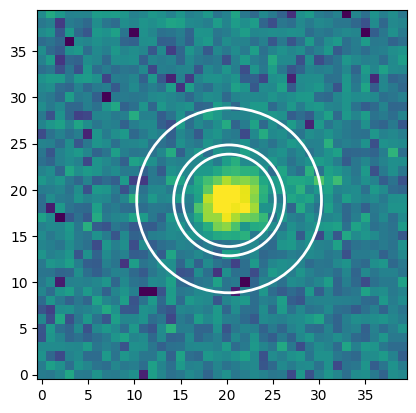

{'mjd': 52190.3303009, 'exptime': 180.0, 'magnitude': -10.81033725410127, 'sky': -9.871676212289593}
Filename: data/8_Oct/td10r_n2_0167.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.3375926
exposition :  180.0  secs
resultats centroid =19.038 ,18.877
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 19.03840494315924 18.876615626838056    252263.66

Sum_target_raw=252263.659

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 19.03840494315924 18.876615626838056    594794.36

Sky_background=594794.360

Target flux without sky=19922.112

instrumental magnitude=-10.748

594794.3600005801


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

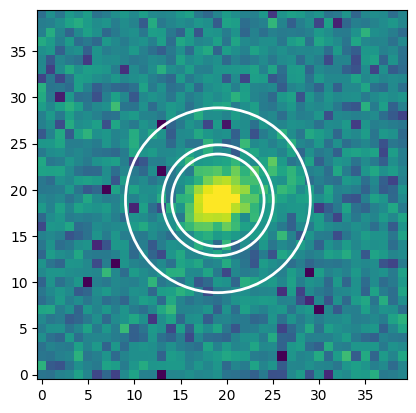

{'mjd': 52190.3375926, 'exptime': 180.0, 'magnitude': -10.748338437237754, 'sky': -9.920467169472408}
Filename: data/8_Oct/td10r_n2_0169.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.344294
exposition :  180.0  secs
resultats centroid =20.093 ,18.684
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 20.093101709588993 18.684345571334195    259987.28

Sum_target_raw=259987.279

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 20.093101709588993 18.684345571334195    611302.48

Sky_background=611302.477

Target flux without sky=21197.249

instrumental magnitude=-10.816

611302.4771690079


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

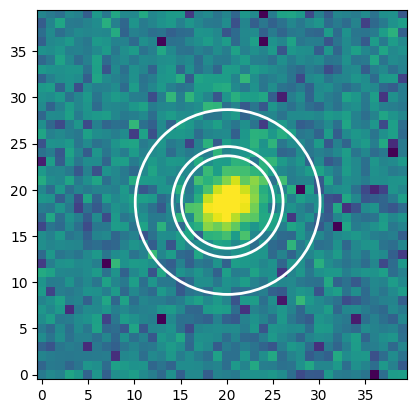

{'mjd': 52190.344294, 'exptime': 180.0, 'magnitude': -10.815698767162626, 'sky': -9.95019045423112}
Filename: data/8_Oct/td10r_n2_0171.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52190.3528472
exposition :  180.0  secs
resultats centroid =19.329 ,18.988
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 19.329003553535266 18.98770354024879    270924.21

Sum_target_raw=270924.209

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 19.329003553535266 18.98770354024879    642862.21

Sky_background=642862.212

Target flux without sky=19806.157

instrumental magnitude=-10.742

642862.2115734799


/tmp/ipykernel_513377/2437244814.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_513377/2437244814.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_513377/2437244814.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_513377/243724

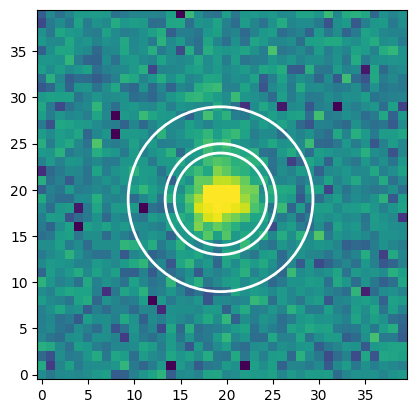

{'mjd': 52190.3528472, 'exptime': 180.0, 'magnitude': -10.742000568558868, 'sky': -10.004844810080778}


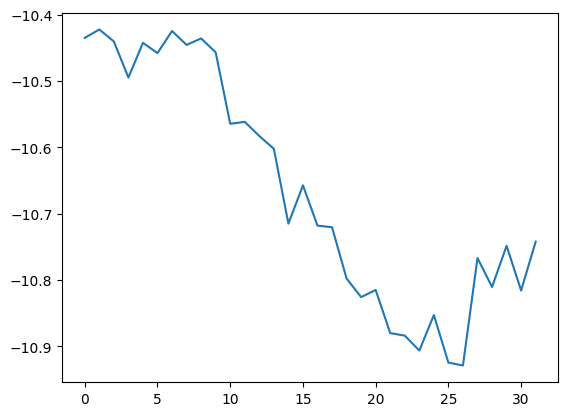

In [9]:

start = (1150, 1156)
# start = (1140, 1186)
end   = (1266, 1109)
# end   = (1128, 1189)
sample_positions = len(files)



r=5        # radius for measuring target flux
r_in=6     # inner radius for the annulus used for measuring sky background
r_out=10    # outer radius for the annulus used for measuring sky background 



# The positions here consider all images aligned.
interpolated = np.round(PositionInterpolation(start, end, sample_positions))
# Let's use the given thingy to get the mag

dic = []
for i, f in enumerate(files):
    Xcent = int(interpolated[i][0] + absolute_offsets[i][0])
    Ycent = int(interpolated[i][1] + absolute_offsets[i][1])


    foo = GivenFileThingy(f, r, r_in, r_out, Xcent, Ycent, 20, debug=True)
    #                                                                  ^ leave to true or buggy

    print(foo)
    dic.append(foo)

# print(len(dic))
# print([ i for i in range(len(dic))], [i["magnitude"] for i in dic])
plt.show()

plt.plot([i for i in range(len(dic))], [i["magnitude"] for i in dic])
plt.show()


## Coordinates determination using Plate Solving on astrometry.net

The plate solving results are available [here](https://nova.astrometry.net/user_images/11285189#annotated). 

```
Center (RA, Dec):	(18.420, 6.057)
Center (RA, hms):	01h 13m 40.890s
Center (Dec, dms):	+06° 03' 24.197"
Size:	13.5 x 13.6 arcmin
Radius:	0.160 deg
Pixel scale:	0.395 arcsec/pixel
```

SIMBAD request on the coordinates using ALADIN gives the following :

![simbad 8](./rsc/ALADIN_8.png)

2MASS operates in the IR bands. 
Selected star is [2MASS J01132281+0607541](https://vizier.cds.unistra.fr/viz-bin/VizieR-S?2MASS%20J01132281%2b0607541) with the 

Searching on VIZIER for stars on that position yields only one result, with $R_{mag} = 13.1$ 


Image is not overexposed so we're not clipping => we're good

1701465.8385353424


/tmp/ipykernel_513377/2437244814.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Magnitude=-2.5*log10(Sum_target)
/tmp/ipykernel_513377/2437244814.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sky_magnitude = -2.5 * log10(Sky_flux)


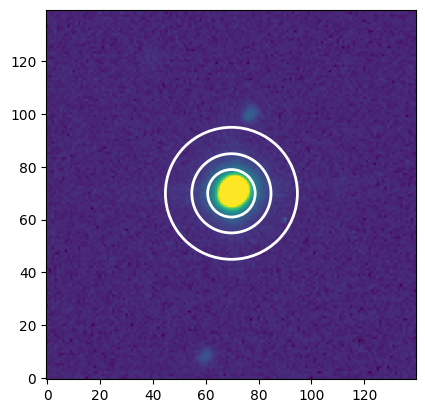

Mag_obs : -16.60138466891357	 2MASS : 13.1	 Offset : 29.70138466891357


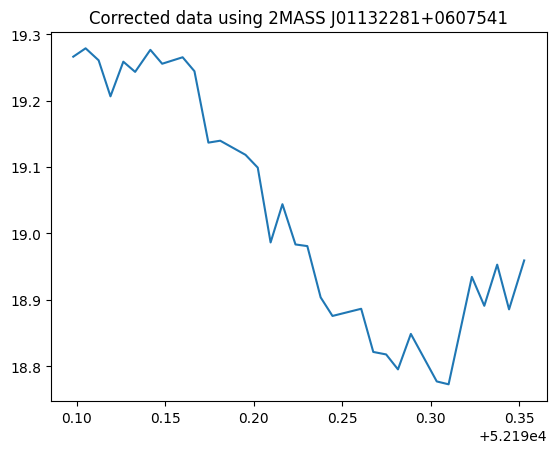

In [10]:
Ref_star = (1115, 680)
Ref_star = (1677, 1740)
mag_obs = GivenFileThingy(files[0], 9, 15, 25, Ref_star[0], Ref_star[1], 70)["magnitude"]
plt.show() # why is it always displaying something
mag_2MASS = 13.1

mag_offset = mag_2MASS-mag_obs

print(f'Mag_obs : {mag_obs}\t 2MASS : {mag_2MASS}\t Offset : {mag_offset}')

# corrected data
corrected_data = [i["magnitude"]+mag_offset for i in dic]
plt.plot([i["mjd"] for i in dic], corrected_data)
plt.title("Corrected data using 2MASS J01132281+0607541")
plt.show()


# create a new dic with corrected data : 
for i in range(len(dic)):
    dic[i]["magnitude"]+=mag_offset




# Rotation period computation

We consider the magnitude of the object to vary in a sinusoidal fashion.

fitting to a sinusoid for the first night

52190.0979167
Fitted parameters: omega = 0.32516196349521426, phi = 1.0036371589710802, offset = 19.043473129603896, amplitude = 0.22839730191075003


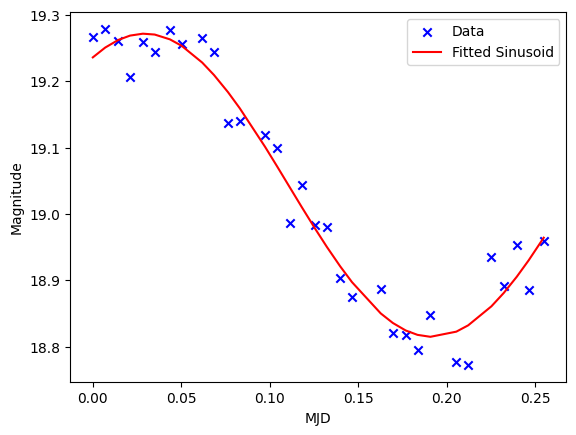

Mean magnitude : 	19.043473129603896
Magnitude variation : 	0.45679460382150006
Period : 		0.32516196349521426 


In [11]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sinusoidal function to fit
def sinusoid(x, amp, a, b, c):
    return amp * np.sin((2 * np.pi / a) * x + b) + c

# MJD offset
mjd_offset=dic[0]["mjd"]
print(mjd_offset)


# Example data (assuming dic is a dictionary with 'mjd' and 'magnitude' entries)
x = np.array([dic[i]["mjd"]-mjd_offset for i in range(len(dic))])
y = np.array([dic[i]["magnitude"] for i in range(len(dic))])

# Approximate values based on your observations
approx_a = 0.32  # frequency to achieve period of about 60
approx_b = 0               # phase offset (adjust if you have an estimate)
approx_c = 17              # vertical offset around 17
approx_amp = 1              # vertical offset around 17

# Initial guess for parameters
initial_guess = [approx_amp, approx_a, approx_b, approx_c]

# Perform the curve fitting
params, covariance = curve_fit(sinusoid, x, y, p0=initial_guess)

# Extract the optimal parameters
amp_opt, a_opt, b_opt, c_opt = params
print(f"Fitted parameters: omega = {a_opt}, phi = {b_opt}, offset = {c_opt}, amplitude = {amp_opt}")

# Calculate the fitted sinusoid for plotting
y_fit = sinusoid(x, amp_opt, a_opt, b_opt, c_opt)

# Plot the data and the fitted curve
plt.scatter(x, y, label='Data', color='blue', marker="x")
plt.plot(x, y_fit, label='Fitted Sinusoid', color='red')
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

print(f'Mean magnitude : \t{c_opt}\nMagnitude variation : \t{amp_opt*2}\nPeriod : \t\t{a_opt} ')

In [12]:
def mjd_to_hours(mjd):
    return mjd * 24

mjd_to_hours(a_opt)

7.803887123885142

# Dump data to ascii file

In [13]:
import csv

# Specify the output ASCII file path
output_file = "8_oct.txt"

# Write each dictionary to a new line in the file with each column as a key
with open(output_file, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=dic[0].keys(), delimiter='\t')
    writer.writeheader()
    writer.writerows(dic)